# Create RoBERTa Model with Classification Layer

In [1]:
!pip install tensorflow-datasets --quiet
!pip install tensorflow-text --quiet
!pip install pydot --quiet
!pip install nltk --quiet
!pip install transformers --quiet
!pip install pyarrow -quiet


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -u


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
import random
import re

nltk.download('gutenberg')
from nltk.corpus import gutenberg

nltk.download('punkt')
from nltk.tokenize import sent_tokenize

#from google.colab import drive

import pyarrow as pya
import pyarrow.parquet as pq

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Dragon\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dragon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Mount drive to retrieve data frame
drive.mount('/content/drive')

In [ ]:
print(tf.__version__)

In [3]:
from transformers import TFRobertaModel , TFRobertaForSequenceClassification, RobertaTokenizer

checkpoint = 'roberta-base'
roberta_tokenizer = RobertaTokenizer.from_pretrained(checkpoint)

In [4]:
MAX_SEQUENCE_LENGTH = 128
DATA_LOC = 'local'  # set to local or remote
SEED_VALUE = 42

In [5]:
# Create RoBERTa with CNN
# multi-modal or multi-channel approach, where the RoBERTa model processes the input text,
# and the CNN layer processes the sequential embeddings produced by RoBERTa.
# This can be beneficial when you want to capture local patterns and relationships
# in addition to the global contextual information provided by the transformer model.
def create_roberta_cnn(num_train_layers=0,
                       num_classes=2,
                       hidden_size=50,
                       dropout=0.1,
                       learning_rate=0.001,
                       lr_schedule=False,
                       type='multi'):
    
  roberta_model  = TFRobertaModel.from_pretrained(checkpoint)

  if num_train_layers == 0:
    # Freeze all layers of pre-trained BERT model
    roberta_model.trainable = False
  elif num_train_layers == 12:
    # Train all layers of the BERT model
    roberta_model.trainable = True
  else:
    # Restrict training to the num_train_layers outer transformer layers
    layers_to_train = roberta_model.layers[-num_train_layers:]
    for layer in layers_to_train:
      layer.trainable = True

  input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
  attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')

  inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

  roberta_out = roberta_model(inputs)[0]  # Extract the last hidden state

  cnn_layers = [
        tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu',name='CNN1'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', name='CNN2'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu', name='CNN3'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', name='CNN4'),
        tf.keras.layers.MaxPooling1D()
  ]

  cnn_out = roberta_out
  for layer in cnn_layers:
      cnn_out = layer(cnn_out)

  # Global max pooling layer to reduce dimensionality
  cnn_out = tf.keras.layers.GlobalMaxPooling1D()(cnn_out)

  cnn_out = tf.keras.layers.Flatten()(cnn_out)

  # Dense layer for classification
  #output = tf.keras.layers.Dense(num_classes, activation='softmax', name = 'output layer')(pooled_out)

  # Fully connected layers for classification
  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(cnn_out)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)
  #hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer2')(hidden)

  if type == 'multi':
    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden)
  else:
    classification = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='classification_layer')(hidden)

  roberta_cnn_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

  # Exclude non-trainable variables from the list of trainable variables
  #trainable_vars = [var for var in roberta_cnn_model.trainable_variables if 'pooler' not in var.name]

  # Use a learning rate scheduler
  if (lr_schedule):
    initial_learning_rate = learning_rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate,
      decay_steps=100,  # Adjust this value based on your preference
      decay_rate=0.9,     # Adjust this value based on your preference
      staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  if type == 'multi':
    roberta_cnn_model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            metrics=['accuracy'])
  else:
    roberta_cnn_model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                            metrics=['accuracy'])

  return roberta_cnn_model

In [6]:
# clear any old model parameters
tf.keras.backend.clear_session()
tf.random.set_seed(SEED_VALUE)

model = create_roberta_cnn(num_classes=7, 
                           num_train_layers=4, 
                           hidden_size=128, 
                           learning_rate=0.0001,
                           lr_schedule = False,
                           dropout=0.2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
model.summary()

In [7]:
def create_encoding(data, label):
  data_encodings = roberta_tokenizer(data,
                        max_length=MAX_SEQUENCE_LENGTH,
                        truncation=True,
                        padding='max_length',
                        return_tensors='tf')

  label_encodings = np.array(label)
  # label_encodings = torch.tensor(label)

  return (data_encodings, label_encodings)



In [8]:
# ###############################################################################
# Load data
# ###############################################################################
def load_data(f_name):
    if DATA_LOC == 'local':
        #os.chdir('D:/MIDS/W266/Project/Data/')
        #file_path = 'D:/MIDS/W266/Project/Data/'
        file_path = 'D:/MIDS/W266/Project/Data/'
    else:
        file_path = "/content/drive/My Drive/w266/data/"

    data = pya.parquet.read_table(file_path+f_name)
    df = data.to_pandas()

    return(df)

In [9]:
df_train = load_data('train_bal_case14.parquet')
df_test = load_data('test_case14.parquet')

In [ ]:
len(df_train)

In [10]:
# #########################################
# DEVELOP spaCy MODELS
# #########################################
!pip install spacy --quiet
!python -m spacy download en_core_web_sm

import spacy

nlp = spacy.load("en_core_web_sm")
spacy_limit = 1000000

Defaulting to user installation because normal site-packages is not writeable
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:
# ##############################################################################
# Use spacy to find and replace person names
#
# keep
#    0: find name and remove
#    1: replace name and keep 
#
# replace
#    text to replace name with
# ##############################################################################
def perform_NER(text, keep = True, replace = 'PERSON'):
    modified_tokens = []
    
    doc = nlp(text)
    for token in doc:
        #print(token.text)
        #print(token.ent_type_)
        if token.ent_type_ == 'PERSON': #in ('PERSON'):  # 'GPE', 'WORK_OF_ART'
            if (keep):
                modified_tokens.append(replace + token.whitespace_)
        else:
            #print(token.text)
            modified_tokens.append(token.text_with_ws)
            #print(modified_tokens)
    doc_wo_names = ''.join(modified_tokens)
    #print(doc_wo_names)
    return(doc_wo_names)

def get_NER_data(df_data, keep = True, replace = 'PERSON'):
    data  = []
    label = []
    
    for indx, row in df_data.iterrows():
        data.append(perform_NER(row[0], keep=keep, replace=replace))
        #data.append(row[0])
        label.append(row[1])
        
    return (data,label)

# Without using NER
def get_data(df_data):
    data  = []
    label = []
    
    for indx, row in df_train.iterrows():
        data.append(row[0])
        label.append(row[1])
        
    return (data,label)

In [12]:
# ######################################################################
# Create Train and Validation encodings - 1
# ######################################################################
NER = True
BATCH_SIZE = 32
SPLIT = 0.8

if (NER):
    train_data, train_label = get_NER_data(df_train, keep=False)
    test_data, test_label = get_NER_data(df_test, keep=False)
else:
    train_data, train_label = get_data(df_train)
    test_data, test_label = get_data(df_test)

split_index = int(len(train_data)*SPLIT)

In [13]:
# ######################################################################
# Create Train and Validation encodings - 2
# ######################################################################
train = list(zip(train_data,train_label))
np.random.shuffle(train)
x, y = zip(*train)

train_data, valid_data = x[:split_index], x[split_index:]
train_label,valid_label= y[:split_index], y[split_index:]

In [14]:
# ######################################################################
# Create Train and Validation encodings - 3
# ######################################################################

# *********************************************************************
# Adjustment factor to use a smaller dataset for faster initial testing
factor = 1
if factor < 1:
    split_train = int(len(train_data)*factor)
    split_valid = int(len(valid_data)*factor)
    
    train_data = train_data[:split_train]
    train_label= train_label[:split_train]
    valid_data = valid_data[:split_valid] 
    valid_label= valid_label[:split_valid]
# ***********************************************************************

In [15]:
# ######################################################################
# Create Train and Validation encodings - 4
# ######################################################################

#test_data = []
#test_label= []
# ***********************************************************************
# Load Test Data 
#for indx, row in df_test.iterrows():
#  test_data.append(row[0])
#  test_label.append(row[1])
# ***********************************************************************

# Create a dataset
train_encodings, train_enc_label = create_encoding(train_data, train_label)
valid_encodings, valid_enc_label = create_encoding(valid_data, valid_label)
test_encodings, test_enc_label = create_encoding(test_data, test_label)

In [16]:
# ######################################################################
# Create Train and Validation encodings - 5
# ######################################################################

dataset_training = tf.data.Dataset.from_tensor_slices(
    (
        {
            'input_ids': train_encodings['input_ids'],
            #'token_type_ids': train_encodings['token_type_ids'],
            'attention_mask': train_encodings['attention_mask']
        },
        train_enc_label
    )
)

dataset_validation = tf.data.Dataset.from_tensor_slices(
    (
        {
            'input_ids': valid_encodings['input_ids'],
            #'token_type_ids': valid_encodings['token_type_ids'],
            'attention_mask': valid_encodings['attention_mask']
        },
        valid_enc_label
    )
)

# Shuffle and batch the dataset
dataset_training   = dataset_training.shuffle(buffer_size=len(train_enc_label)).batch(BATCH_SIZE)
dataset_validation = dataset_validation.shuffle(buffer_size=len(valid_enc_label)).batch(BATCH_SIZE)
#dataset_training   = dataset_training.batch(BATCH_SIZE)
#dataset_validation = dataset_validation.batch(BATCH_SIZE)

In [ ]:
keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [17]:
# Define a callback to save weights after each batch
from tensorflow.keras.callbacks import Callback

class SaveWeightsCallback(Callback):
    def __init__(self, model_name):
        super(SaveWeightsCallback, self).__init__()
        self.model_name = model_name

    #def on_batch_end(self, batch, logs=None):
    #    model_filename = f"/content/drive/My Drive/w266/training/{self.model_name}_weights.h5"
    #    self.model.save_weights(model_filename)

    def on_epoch_end(self, epoch, logs=None):
        if DATA_LOC == 'local':
            model_filename = f"D:/MIDS/W266/Project/Training/{self.model_name}_weights_epoch{epoch}.h5" 
        else:
            model_filename = f"/content/drive/My Drive/w266/training/{self.model_name}_weights_epoch{epoch}.h5"
            
        self.model.save_weights(model_filename)

# Create a custom callback to stop within a single epoch if accuracy doesn't change much between iterations
class CustomStopCallbackWithinEpoch(Callback):
    def __init__(self, delta=0.01, patience=2, threshold=0.50):
        super(CustomStopCallbackWithinEpoch, self).__init__()
        self.delta = delta
        self.patience = patience
        self.threshold = threshold
        self.wait = 0
        self.best_accuracy = -1

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')

        if accuracy is not None and accuracy > self.threshold:
            if np.abs(accuracy - self.best_accuracy) > self.delta:
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.model.stop_training = True
                    print(f"\nStopping training within epoch {epoch + 1} because accuracy hasn't improved for the last {self.patience} iterations.")
            if accuracy > self.best_accuracy:
              self.best_accuracy = accuracy

In [18]:
save_weights_callback = SaveWeightsCallback(model_name='roberta_multi_bal_Case14')
custom_stop_callback = CustomStopCallbackWithinEpoch(delta=0.01, patience=2, threshold=0.7)

In [19]:
# Train the model with the SaveWeightsCallback
#model_history = model.fit(
#    dataset_training,
#    validation_data=dataset_validation,
#    epochs=1,
#    callbacks=[save_weights_callback, custom_stop_callback])

model_history = model.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=1,
    callbacks=save_weights_callback)

145/145 [==============================] - 1633s 11s/step - loss: 1.5694 - accuracy: 0.3771 - val_loss: 1.1090 - val_accuracy: 0.5628


In [20]:
# AS NEEDED: Reload weights and run for longer
wgt_file = 'roberta_multi_bal_Case14_weights_epoch0.h5'

if DATA_LOC == 'local':
    #os.chdir('D:/MIDS/W266/Project/Data/')
    wgt_path = 'D:/MIDS/W266/Project/Training/'
else:
    wgt_path = '/content/drive/My Drive/w266/training/'
    
model.load_weights(wgt_path+wgt_file)

In [21]:
# AS NEEDED: Reload weights and run for longer
model_history = model.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=4,
    callbacks=save_weights_callback)

Epoch 1/4
145/145 [==============================] - 1381s 10s/step - loss: 0.9969 - accuracy: 0.6132 - val_loss: 1.1315 - val_accuracy: 0.5688
Epoch 2/4
145/145 [==============================] - 1358s 9s/step - loss: 0.7866 - accuracy: 0.7175 - val_loss: 0.7539 - val_accuracy: 0.7325
Epoch 3/4
145/145 [==============================] - 1372s 9s/step - loss: 0.6150 - accuracy: 0.7994 - val_loss: 0.5791 - val_accuracy: 0.7991
Epoch 4/4
145/145 [==============================] - 1342s 9s/step - loss: 0.4742 - accuracy: 0.8485 - val_loss: 0.7758 - val_accuracy: 0.7558


In [ ]:
# OPTIONAL: create a smaller Test dataset
test_data_small = []
test_label_small = []
size_factor = 0.1

size = int(size_factor*len(df_test))

for indx, row in df_test.iterrows():
  if indx < size:
    test_data_small.append(row[0])
    test_label_small.append(row[1])
  else:
    break

test_encodings_small, test_enc_label_small = create_encoding(test_data_small, test_label_small)

In [ ]:
# OPTIONAL: Create Test NER
test_data_NER, test_label_NER = get_NER_data(df_test)
test_encodings_NER, test_enc_label_NER = create_encoding(test_data_NER, test_label_NER)


In [26]:
# AS NEEDED: Reload weights
wgt_file = 'roberta_multi_bal_Case14_weights_epoch2.h5'

if DATA_LOC == 'local':
    #os.chdir('D:/MIDS/W266/Project/Data/')
    wgt_path = 'D:/MIDS/W266/Project/Training/'
else:
    wgt_path = '/content/drive/My Drive/w266/training/'
    
model.load_weights(wgt_path+wgt_file)

In [27]:
# Uncomment to run predictions against the full test set
predictions = model.predict([test_encodings.input_ids, test_encodings.attention_mask])

# Uncomment to run predictions against the smaller subset test set
#predictions = model.predict([test_encodings_small.input_ids, test_encodings_small.attention_mask])

# Uncomment to run predictions against itself by using the training set as test
#predictions_train = model.predict([train_encodings.input_ids, train_encodings.attention_mask])

# Uncomment to run predictions against the full test set with entities replaced but kept
#predictions_NER = model.predict([test_encodings_NER.input_ids, test_encodings_NER.attention_mask])

115/115 [==============================] - 291s 3s/step


In [29]:
pred_file = 'roberta_prediction.csv'

if DATA_LOC == 'local':
    #os.chdir('D:/MIDS/W266/Project/Prediction/')
    pred_path = 'D:/MIDS/W266/Project/Prediction/'
else:
    pred_path = '/content/drive/My Drive/w266/'
    
np.savetxt(pred_path+pred_file, predictions)

In [23]:
# ####################################################################
# Functions for creating and showing confusion
# ####################################################################
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def create_confusion(test, pred):
    prediction_max = []
    for i in range(len(pred)):
      prediction_max.append(np.argmax(pred[i]))
    
    # *********************************************************************************
    # Metrics from Training
    #
    # when called after Training, is the last known values
    # *********************************************************************************
    # Calculate accuracy using TensorFlow
    accuracy = tf.keras.metrics.Accuracy()
    accuracy.update_state(test, prediction_max)
    accuracy_result = accuracy.result().numpy()
    
    # Calculate precision, recall, and F1 score using TensorFlow
    precision = tf.keras.metrics.Precision()
    precision.update_state(test, prediction_max)
    precision_result = precision.result().numpy()

    recall = tf.keras.metrics.Recall()
    recall.update_state(test, prediction_max)
    recall_result = recall.result().numpy()

    f1 = 2 * (precision_result * recall_result) / (precision_result + recall_result)
    
    #print("\nAccuracy:", accuracy_result)
    #print("\nPrecision:", precision_result)
    #print("Recall:", recall_result)
    #print("F1 Score:", f1)
    # *********************************************************************************
    
    # *********************************************************************************
    # Generate confusion matrix from Test set
    #
    # Rows are Actuals (Test labels)
    # Cols are prericted values
    #
    # FN measured across row
    # FP measured down column
    # *********************************************************************************
    conf_matrix = confusion_matrix(test, prediction_max)
    
    # Print confusion matrix and metrics
    print("Confusion Matrix:")
    print(conf_matrix)

    # Classification report using scikit-learn
    class_report = classification_report(test, prediction_max)
    print("\nClassification Report:")
    print(class_report)
    
    return(conf_matrix)

def show_confusion(conf_matrix):
    # Set row labels
    class_labels = ["Fitzgerald", "Hemingway", "Hardy", "Dickens", "Austen", "Chesterton", "Shakespeare"]
    
    # Confusion matrix with counts
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True)
    plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    ax = plt.gca()
    ax.xaxis.set_ticks_position("top")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Confusion matrix as percentage of counts
    conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", square=True, xticklabels=True, yticklabels=True)
    plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    ax = plt.gca()
    ax.xaxis.set_ticks_position("top")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix with Percentages")
    plt.show()
    
    #####################################################
    

Confusion Matrix:
[[444   8  36  15   1  26   3]
 [ 10 270   4  14   0   5   3]
 [ 11   4 506  28  36  20   6]
 [  6   6 208 546 109  41  24]
 [  1   1  44  22 414   0   1]
 [ 48   2  32  18   2 234   1]
 [  2   0   4   5   1   0 452]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       533
           1       0.93      0.88      0.90       306
           2       0.61      0.83      0.70       611
           3       0.84      0.58      0.69       940
           4       0.74      0.86      0.79       483
           5       0.72      0.69      0.71       337
           6       0.92      0.97      0.95       464

    accuracy                           0.78      3674
   macro avg       0.80      0.81      0.80      3674
weighted avg       0.80      0.78      0.78      3674



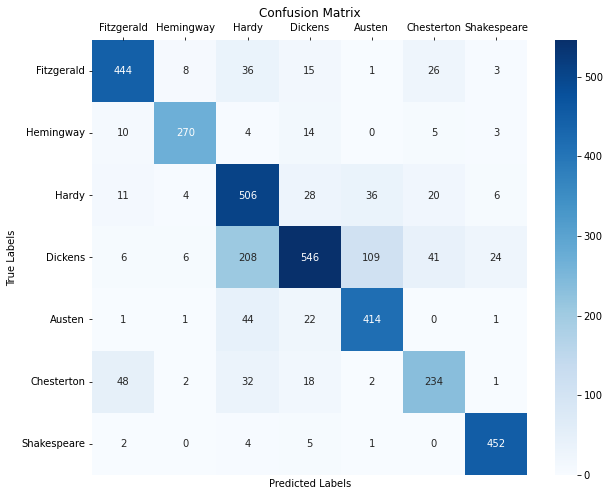

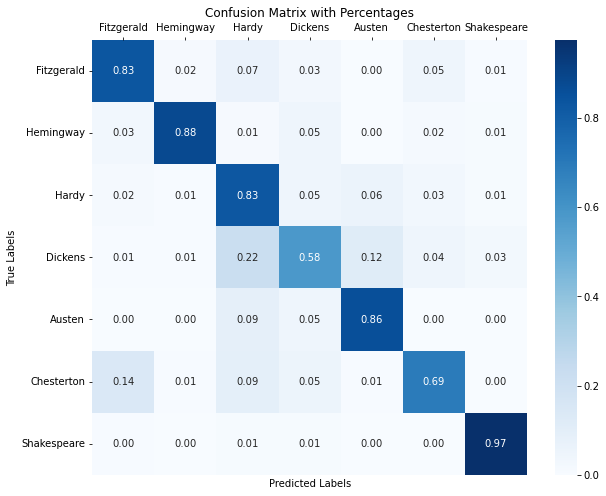

In [28]:
# Uncomment to test predictions against training data
#conf = create_confusion(train_enc_label, predictions_train)

# Uncomment to test predictions against small test data set
#conf = create_confusion(test_label_small, predictions)

# Uncomment to test predictions against full test data set
conf = create_confusion(test_label, predictions)

#conf = create_confusion(test_enc_label_NER, predictions_NER)

show_confusion(conf)

In [ ]:
# Find incorrect matches
counter=0
for i in range(len(predictions_train)):
    indx = np.argmax(predictions_train[i],axis=0)
    if train_label[i] != int(indx):
        counter += 1
        print(i)
        print(train_data[i])
        print("test label: " + str(train_label[i]))
        print("pred label: " + str(indx))
        print("***************************")

print("count: " + str(counter))

# Binary Classification Processing

In [ ]:
# ##########################################################
# BINARY CLASSIFICATION
# ##########################################################
# Load training data
# Load Test Data and prepare encodings
if DATA_LOC == 'local':
    #os.chdir('D:/MIDS/W266/Project/Data/')
    #file_path = 'D:/MIDS/W266/Project/Data/'
    file_path = 'D:/MIDS/W266/Project/Data/Bin/'
else:
    file_path = "/content/drive/My Drive/w266/data/"

# Load data and provide train / valid split
train_file = file_path + "train_case13_bin_3.parquet"
#valid_file = file_path + "datatest_valid_bal.parquet"
test_file  = file_path + "test_case13_bin_3.parquet"

#train_file = file_path + "gut_corpus_train_data_multi_bal.parquet"
#valid_file = file_path + "gut_corpus_valid_data_multi_bal.parquet"
#test_file = file_path + "gut_corpus_test_data_multi_bal.parquet"

#train_file = file_path + "gut_corpus_train_data_binary6_small.parquet"
#valid_file = file_path + "gut_corpus_valid_data_binary6_small.parquet"
#test_file = file_path + "gut_corpus_test_data_binary6_small.parquet"

data = pya.parquet.read_table(train_file)
df_train = data.to_pandas()
#data = pya.parquet.read_table(valid_file)
#df_valid = data.to_pandas()
data = pya.parquet.read_table(test_file)
df_test = data.to_pandas()

# ###################################################################

# Create Train and Validation encodings
NER = True
BATCH_SIZE = 32
SPLIT = 0.8

train_data = []
train_label = []
valid_data = []
valid_label = []
test_data  = []
test_label = []

if (NER):
    train_data, train_label = get_NER_data(df_train, keep=False)
else:
    train_data, train_label = get_data(df_train)
    
#for indx, row in df_train.iterrows():
#    train_data.append(row[0])
#    train_label.append(row[1])

split_index = int(len(train_data)*SPLIT)
    
train = list(zip(train_data,train_label))
np.random.shuffle(train)
x, y = zip(*train)

train_data, valid_data = x[:split_index], x[split_index:]
train_label,valid_label= y[:split_index], y[split_index:] 

# ***********************************************************************
# Adjustment factor to use a smaller dataset for faster initial testing
factor = 0.2
if factor < 1:
    split_train = int(len(train_data)*factor)
    split_valid = int(len(valid_data)*factor)
    
    train_data = train_data[:split_train]
    train_label= train_label[:split_train]
    valid_data = valid_data[:split_valid] 
    valid_label= valid_label[:split_valid]
# ***********************************************************************

# ***********************************************************************
# Load Test Data 
for indx, row in df_test.iterrows():
  test_data.append(row[0])
  test_label.append(row[1])
# ***********************************************************************

# Create a dataset
train_encodings, train_enc_label = create_encoding(train_data, train_label)
valid_encodings, valid_enc_label = create_encoding(valid_data, valid_label)
test_encodings, test_enc_label = create_encoding(test_data, test_label)

dataset_training = tf.data.Dataset.from_tensor_slices(
    (
        {
            'input_ids': train_encodings['input_ids'],
            'attention_mask': train_encodings['attention_mask']
        },
        train_enc_label
    )
)

dataset_validation = tf.data.Dataset.from_tensor_slices(
    (
        {
            'input_ids': valid_encodings['input_ids'],
            'attention_mask': valid_encodings['attention_mask']
        },
        valid_enc_label
    )
)

# Shuffle and batch the dataset
dataset_training   = dataset_training.shuffle(buffer_size=len(train_enc_label)).batch(BATCH_SIZE)
dataset_validation = dataset_validation.shuffle(buffer_size=len(valid_enc_label)).batch(BATCH_SIZE)

In [ ]:
# Run Binary
# clear any old model parameters
tf.keras.backend.clear_session()

tf.random.set_seed(SEED_VALUE)

#bert_multiclass_model = create_bert_multiclass_model(bert_model,7)
#bert_model_multi = create_bert_multiclass_model(bert_model,7)
roberta_model_bin = create_roberta_cnn(num_classes=1,
                                        dropout=0.2,
                                        num_train_layers=4,
                                        learning_rate=0.0001,
                                        hidden_size=128,
                                        lr_schedule=False,
                                        type='bin')

In [ ]:
# Train the model with the SaveWeightsCallback
save_weights_callback = SaveWeightsCallback(model_name='roberta_bin_bal_NER_nokeep_6_Case13')
model_history = roberta_model_bin.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=1,
    callbacks=save_weights_callback)

# Load model and run predictions

In [ ]:
# AS NEEDED: Reload weights and run for longer
wgt_file = 'roberta_bin_bal_NER_nokeep_3_Case13_weights_epoch0.h5'

if DATA_LOC == 'local':
    #os.chdir('D:/MIDS/W266/Project/Data/')
    wgt_path = 'D:/MIDS/W266/Project/Training/'
else:
    wgt_path = '/content/drive/My Drive/w266/training/'
    
roberta_model_bin.load_weights(wgt_path+wgt_file)

In [ ]:
# OPTIONAL: Retrain
save_weights_callback = SaveWeightsCallback(model_name='roberta_bin_bal_NER_nokeep_3_1_Case13')
model_history = roberta_model_bin.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=1,
    callbacks=save_weights_callback)

In [ ]:
#Encode Test data

test_data = []
test_label= []

# Load Test Data 
for indx, row in df_test.iterrows():
  test_data.append(row[0])
  test_label.append(row[1])

# Create a dataset
test_encodings, test_enc_label = create_encoding(test_data, test_label)



In [ ]:
# Run prediction
predictions = model.predict([test_encodings.input_ids, test_encodings.attention_mask])

In [ ]:
conf = create_confusion(test_label, predictions)
show_confusion(conf)

# Predictions with Balanced Test Dataset

In [ ]:
df_test_bal = load_data('test_bal_case13.parquet')

In [ ]:
len(df_test_bal)

In [ ]:
if (NER):
    test_bal_data, test_bal_label = get_NER_data(df_test_bal, keep=False)
else:
    test_bal_data, test_bal_label = get_data(df_test_bal)


test_bal_encodings, test_bal_enc_label = create_encoding(test_bal_data, test_bal_label)

In [ ]:
len(test_bal_data)

In [ ]:
predictions = model.predict([test_bal_encodings.input_ids, test_bal_encodings.attention_mask])
conf = create_confusion(test_bal_label, predictions)
show_confusion(conf)

# Analysis 

In [30]:
df_train_small = load_data('train_bal_case14.parquet')
df_train_large = load_data('train_case14.parquet')

words_small = []
words_large = []

for indx, row in df_train_small.iterrows():
    doc = nlp(row[0])
    words = [token.text for token in doc if token.is_alpha]
    words_small.append(words)
    
for indx, row in df_train_large.iterrows():
    doc = nlp(row[0])
    words = [token.text for token in doc if token.is_alpha]
    words_large.append(words)
    

# flatten the word lists
words_small = [item for sublist in words_small for item in sublist]
words_large = [item for sublist in words_large for item in sublist]

In [50]:
words_small_sorted = sorted(words_small)
words_large_sorted = sorted(words_large)

print(words_small_sorted[100:1000])
print(words_large_sorted[100:1000])

['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'ACC

In [31]:
import nltk
import seaborn as sns

nltk.download("stopwords")

sw = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dragon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
words_small_removed = []
for word in words_small:
    if word.lower() not in sw: # use lower so that both He and he are removed
        words_small_removed.append(word)
        
words_large_removed = []
for word in words_large:
    if word.lower() not in sw: # use lower so that both He and he are removed
        words_large_removed.append(word)

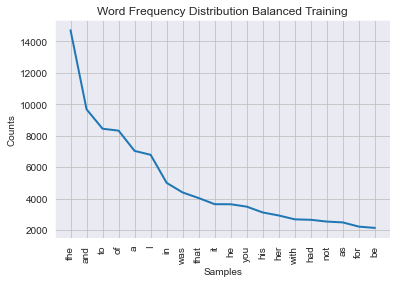

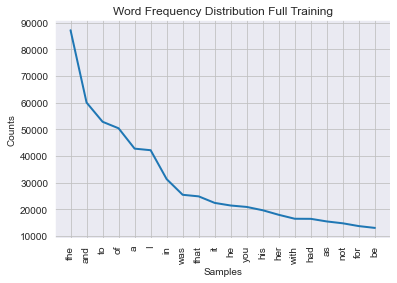

In [66]:

sns.set_style('darkgrid')
#nlp_words=nltk.FreqDist(words_small_removed)
nlp_words=nltk.FreqDist(words_small_sorted)
#nlp_words=sorted(nlp_words.items(), key=lambda x: x[0])
nlp_words.plot(20,title="Word Frequency Distribution Balanced Training");

#sorted_words, frequencies = zip(*nlp_words)
#plt.figure(figsize=(10, 6))
#plt.bar(sorted_words, frequencies)
#plt.xlabel("Words")
#plt.ylabel("Frequency")
#plt.title("Word Frequency Distribution")
#plt.show()

sns.set_style('darkgrid')
#nlp_words=nltk.FreqDist(words_large_removed)
nlp_words=nltk.FreqDist(words_large_sorted)
#nlp_words=sorted(nlp_words.items(), key=lambda x: x[0])
nlp_words.plot(20,title='Word Frequency Distribution Full Training');

In [34]:
from collections import Counter
from nltk import ngrams

freq_small = Counter(words_small_removed) #.most_common(100)
freq_large = Counter(words_large_removed) #.most_common(100)

#counted_2= Counter(ngrams(words_small_removed,2))
#counted_3= Counter(ngrams(words_small_removed,3))


In [35]:
print(freq_small.most_common(20))
print(freq_large.most_common(20))

[('said', 1863), ('would', 1066), ('one', 939), ('could', 884), ('like', 751), ('man', 735), ('know', 657), ('little', 569), ('time', 539), ('much', 535), ('think', 492), ('see', 480), ('must', 478), ('never', 472), ('good', 471), ('go', 449), ('say', 447), ('two', 440), ('come', 435), ('came', 405)]
[('said', 10358), ('would', 6121), ('one', 5631), ('could', 5208), ('man', 4273), ('like', 4078), ('know', 3943), ('little', 3767), ('time', 3374), ('much', 3148), ('see', 2950), ('good', 2861), ('say', 2820), ('think', 2768), ('never', 2754), ('come', 2711), ('must', 2702), ('upon', 2658), ('go', 2627), ('two', 2510)]


In [ ]:
freq_small

In [67]:
from scipy.stats import mannwhitneyu

small_counts = list(freq_small.values())[:70]   #.most_common(100))
large_counts = list(freq_large.values())[:70]   #.most_common(100))

u_stat, p_value = mannwhitneyu(small_counts, large_counts)

print("U Statistic:", u_stat)
print("P-Value:", p_value)

# Check significance at a chosen alpha level (e.g., 0.05)
if p_value < 0.05:
    print("The difference is statistically significant.")
else:
    print("There is no significant difference.")

U Statistic: 2046.5
P-Value: 0.09292520234944346
There is no significant difference.


In [ ]:
small_counts